This notebook is used to find the best TF-IDF parameters for the dataset.

Tested in a clean environment with Python 3.10.9.

These are the packages we used

In [1]:
# To perform data manipulation
%pip install pandas==1.5.2

# To monitor progress in long tasks
%pip install tqdm==4.64.1

# Pyarrow is used by pandas to save/load parquet files
%pip install pyarrow==10.0.1

# To process natural text
%pip install nltk==3.8.1

# We will use Auto_ViML to train the model using NLP and AutoML.
# lightgbm and lxml are required by autoviml, as well as version 1.0.2 of scikit-learn
%pip install scikit-learn==1.0.2
%pip install autoviml==0.1.710
%pip install lightgbm==3.3.4
%pip install lxml==4.9.2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Now let's import the necessary modules

In [2]:
import pandas as pd # For data processing

import nltk # For text processing
nltk.download('stopwords') # Stop words
nltk.download('punkt') # Tokenizer
english_stop_words = set(nltk.corpus.stopwords.words('english')) # Saving the stopwords in a list

from tqdm import tqdm # To monitor progress in large tasks
tqdm.pandas() # Configure tqdm to work with pandas

from sklearn.model_selection import train_test_split # To split train/test data
from sklearn.utils import resample # To balance the dataset

from autoviml.Auto_NLP import Auto_NLP # To train our model using AutoML and NLP

import joblib # To save model

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Imported Auto_ViML version: 0.1.710. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


Let's load our dataset, making sure there are no duplicated rows

In [3]:
df_commits_annotated = pd.read_parquet('commits_annotated.parquet.gzip')
print(f'Number of rows: {df_commits_annotated.shape[0]}')
print(f'Number of duplicated: {df_commits_annotated.revision_hash.duplicated().sum()}')
df_commits_annotated.head()

Number of rows: 452284
Number of duplicated: 0


,index,_id,revision_hash,message,isBugfix
0,0,5bef24dc83ad2f56ca1ca7cd,64185d21b51d1ed32c419f443f804ae2e09ee5f8,The the patrol.,False
1,1,5bef24dd83ad2f56ca1ca7d3,37ab026c576c8841f378cc2376ca02c478567e84,Cleanup in commons-rdf-rdf4j to close PMD and FindBugs warnings\n,False
2,2,5bef24dd83ad2f56cb1ca7cd,092c465f996f3a4a6acf3f65aeb76f768e702289,COMMONSRDF-49: Make AbstractRDFParser serializable\n\nMerge commit 'refs/pull/43/head' of https://github.com/apache/commons-rdf\n\nContributed by @ajs6f\n\nThis closes #43\n,False
3,3,5bef24dd83ad2f56cc1ca7cd,6123c7308ed533b870370c6a234ce140368ccc4e,ensure site build works with newest checkstyle plugin\n,False
4,4,5bef24dd83ad2f56cc1ca7d4,25af8121afb778efa20d73e1f10c073ad1917e59,[maven-release-plugin] prepare for next development iteration\n,False


We only need columns 'message' and 'isBugfix'. Let's drop the others

In [4]:
df_commits_annotated.drop(columns=['_id','revision_hash'], inplace=True)
df_commits_annotated.head()

,index,message,isBugfix
0,0,The the patrol.,False
1,1,Cleanup in commons-rdf-rdf4j to close PMD and FindBugs warnings\n,False
2,2,COMMONSRDF-49: Make AbstractRDFParser serializable\n\nMerge commit 'refs/pull/43/head' of https://github.com/apache/commons-rdf\n\nContributed by @ajs6f\n\nThis closes #43\n,False
3,3,ensure site build works with newest checkstyle plugin\n,False
4,4,[maven-release-plugin] prepare for next development iteration\n,False


Now let's try to balance the dataset. As it can be seen, it is highly imbalanced.

In [5]:
df_commits_count = df_commits_annotated['isBugfix'].value_counts()
df_commits_count

False    449379
True       2905
Name: isBugfix, dtype: int64

Let's downsample the majority class. It's okay, since we still have almost 3K "True" values.

In [6]:
df_majority = df_commits_annotated[df_commits_annotated.isBugfix==False]
df_minority = df_commits_annotated[df_commits_annotated.isBugfix==True]

count_minority = df_commits_count[1] # Number of elements in minority class

df_majority_downsampled = resample(df_majority,
                                    replace=False,
                                    n_samples=count_minority,
                                    random_state=42)

df_commits_annotated = pd.concat([df_majority_downsampled, df_minority])

df_commits_annotated['isBugfix'].value_counts()

False    2905
True     2905
Name: isBugfix, dtype: int64

Now let's preprocess our text. First, we will lowercase and remove stopwords. This will be our 'input_feature' column

In [7]:
def lower_case_and_remove_stopwords(text):
    return ' '.join([word for word in nltk.tokenize.word_tokenize(text) if word not in (english_stop_words)])

df_commits_annotated['input_feature'] = df_commits_annotated['message']\
    .str.lower().progress_apply(lower_case_and_remove_stopwords)
df_commits_annotated.head()

100%|██████████| 5810/5810 [00:02<00:00, 2482.74it/s]


,index,message,isBugfix,input_feature
151859,151859,Update installation for impatient\n,False,update installation impatient
332572,332572,Added example for using the reverse mapping tool\n\ngit-svn-id: https://svn.apache.org/repos/asf/incubator/openjpa/trunk@530939 13f79535-47bb-0310-9956-ffa450edef68\n,False,added example using reverse mapping tool git-svn-id : https : //svn.apache.org/repos/asf/incubator/openjpa/trunk @ 530939 13f79535-47bb-0310-9956-ffa450edef68
196656,196656,PDFBOX-2883: remove COSDocument constructors using boolean 'useScratchFiles' parameter and ensure to have an equivalent constructor using MemoryUsageSetting object; default is using main memory only (as before)\n\ngit-svn-id: https://svn.apache.org/repos/asf/pdfbox/trunk@1705688 13f79535-47bb-0310-9956-ffa450edef68\n,False,pdfbox-2883 : remove cosdocument constructors using boolean 'usescratchfiles ' parameter ensure equivalent constructor using memoryusagesetting object ; default using main memory ( ) git-svn-id : https : //svn.apache.org/repos/asf/pdfbox/trunk @ 1705688 13f79535-47bb-0310-9956-ffa450edef68
395182,395182,Added #else formatting test.\nPR:\nObtained from:\nSubmitted by:\nReviewed by:\n\n\ngit-svn-id: https://svn.apache.org/repos/asf/jakarta/velocity/trunk@73892 13f79535-47bb-0310-9956-ffa450edef68\n,False,added # else formatting test . pr : obtained : submitted : reviewed : git-svn-id : https : //svn.apache.org/repos/asf/jakarta/velocity/trunk @ 73892 13f79535-47bb-0310-9956-ffa450edef68
141552,141552,KAFKA-3740: Part I: expose StreamConfig properties in ProcessorContext\n\nThis is the part I of the work to add the StreamsConfig to ProcessorContext.\n\nWe need to access StreamsConfig in the ProcessorContext so other components (e.g. RocksDBWindowStore or LRUCache can retrieve config parameter from application)\n\nAuthor: Henry Cai <hcai@pinterest.com>\n\nReviewers: Guozhang Wang <wangguoz@gmail.com>\n\nCloses #1553 from HenryCaiHaiying/config\n,False,kafka-3740 : part : expose streamconfig properties processorcontext part work add streamsconfig processorcontext . need access streamsconfig processorcontext components ( e.g . rocksdbwindowstore lrucache retrieve config parameter application ) author : henry cai < hcai @ pinterest.com > reviewers : guozhang wang < wangguoz @ gmail.com > closes # 1553 henrycaihaiying/config


Now our 'isBugfix' column needs to be converted from boolean to int: True=1, False=0. This will be our 'target' column

In [8]:
df_commits_annotated['target'] = df_commits_annotated['isBugfix']\
    .progress_apply(lambda x: 1 if x else 0)
df_commits_annotated.head()

100%|██████████| 5810/5810 [00:00<00:00, 537340.00it/s]


,index,message,isBugfix,input_feature,target
151859,151859,Update installation for impatient\n,False,update installation impatient,0
332572,332572,Added example for using the reverse mapping tool\n\ngit-svn-id: https://svn.apache.org/repos/asf/incubator/openjpa/trunk@530939 13f79535-47bb-0310-9956-ffa450edef68\n,False,added example using reverse mapping tool git-svn-id : https : //svn.apache.org/repos/asf/incubator/openjpa/trunk @ 530939 13f79535-47bb-0310-9956-ffa450edef68,0
196656,196656,PDFBOX-2883: remove COSDocument constructors using boolean 'useScratchFiles' parameter and ensure to have an equivalent constructor using MemoryUsageSetting object; default is using main memory only (as before)\n\ngit-svn-id: https://svn.apache.org/repos/asf/pdfbox/trunk@1705688 13f79535-47bb-0310-9956-ffa450edef68\n,False,pdfbox-2883 : remove cosdocument constructors using boolean 'usescratchfiles ' parameter ensure equivalent constructor using memoryusagesetting object ; default using main memory ( ) git-svn-id : https : //svn.apache.org/repos/asf/pdfbox/trunk @ 1705688 13f79535-47bb-0310-9956-ffa450edef68,0
395182,395182,Added #else formatting test.\nPR:\nObtained from:\nSubmitted by:\nReviewed by:\n\n\ngit-svn-id: https://svn.apache.org/repos/asf/jakarta/velocity/trunk@73892 13f79535-47bb-0310-9956-ffa450edef68\n,False,added # else formatting test . pr : obtained : submitted : reviewed : git-svn-id : https : //svn.apache.org/repos/asf/jakarta/velocity/trunk @ 73892 13f79535-47bb-0310-9956-ffa450edef68,0
141552,141552,KAFKA-3740: Part I: expose StreamConfig properties in ProcessorContext\n\nThis is the part I of the work to add the StreamsConfig to ProcessorContext.\n\nWe need to access StreamsConfig in the ProcessorContext so other components (e.g. RocksDBWindowStore or LRUCache can retrieve config parameter from application)\n\nAuthor: Henry Cai <hcai@pinterest.com>\n\nReviewers: Guozhang Wang <wangguoz@gmail.com>\n\nCloses #1553 from HenryCaiHaiying/config\n,False,kafka-3740 : part : expose streamconfig properties processorcontext part work add streamsconfig processorcontext . need access streamsconfig processorcontext components ( e.g . rocksdbwindowstore lrucache retrieve config parameter application ) author : henry cai < hcai @ pinterest.com > reviewers : guozhang wang < wangguoz @ gmail.com > closes # 1553 henrycaihaiying/config,0


Now we will start the training process. First we split the data into train/test

In [9]:
train, test = train_test_split(df_commits_annotated, test_size=0.33, random_state=42)

The we ask Auto_NLP to find the best model for us.
On my machine (a core i7-3770 CPU @ 3.40GHz with no GPU and 12Gb of RAM) this takes around 2 minutes.

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/daniel/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/daniel/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/daniel/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/daniel/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/daniel/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/daniel/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to

Auto NLP processing on NLP Column: input_feature
Shape of Train Data: 3892 rows
    Shape of Test Data: 1918 rows


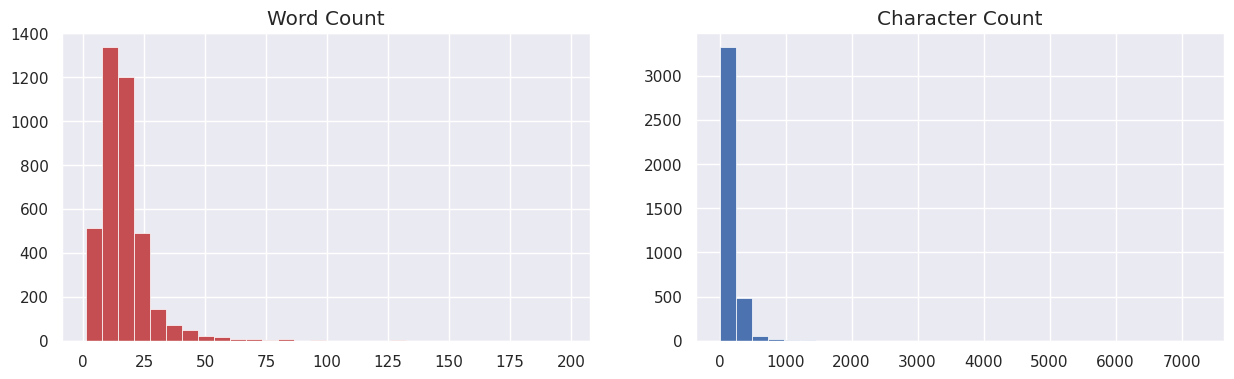

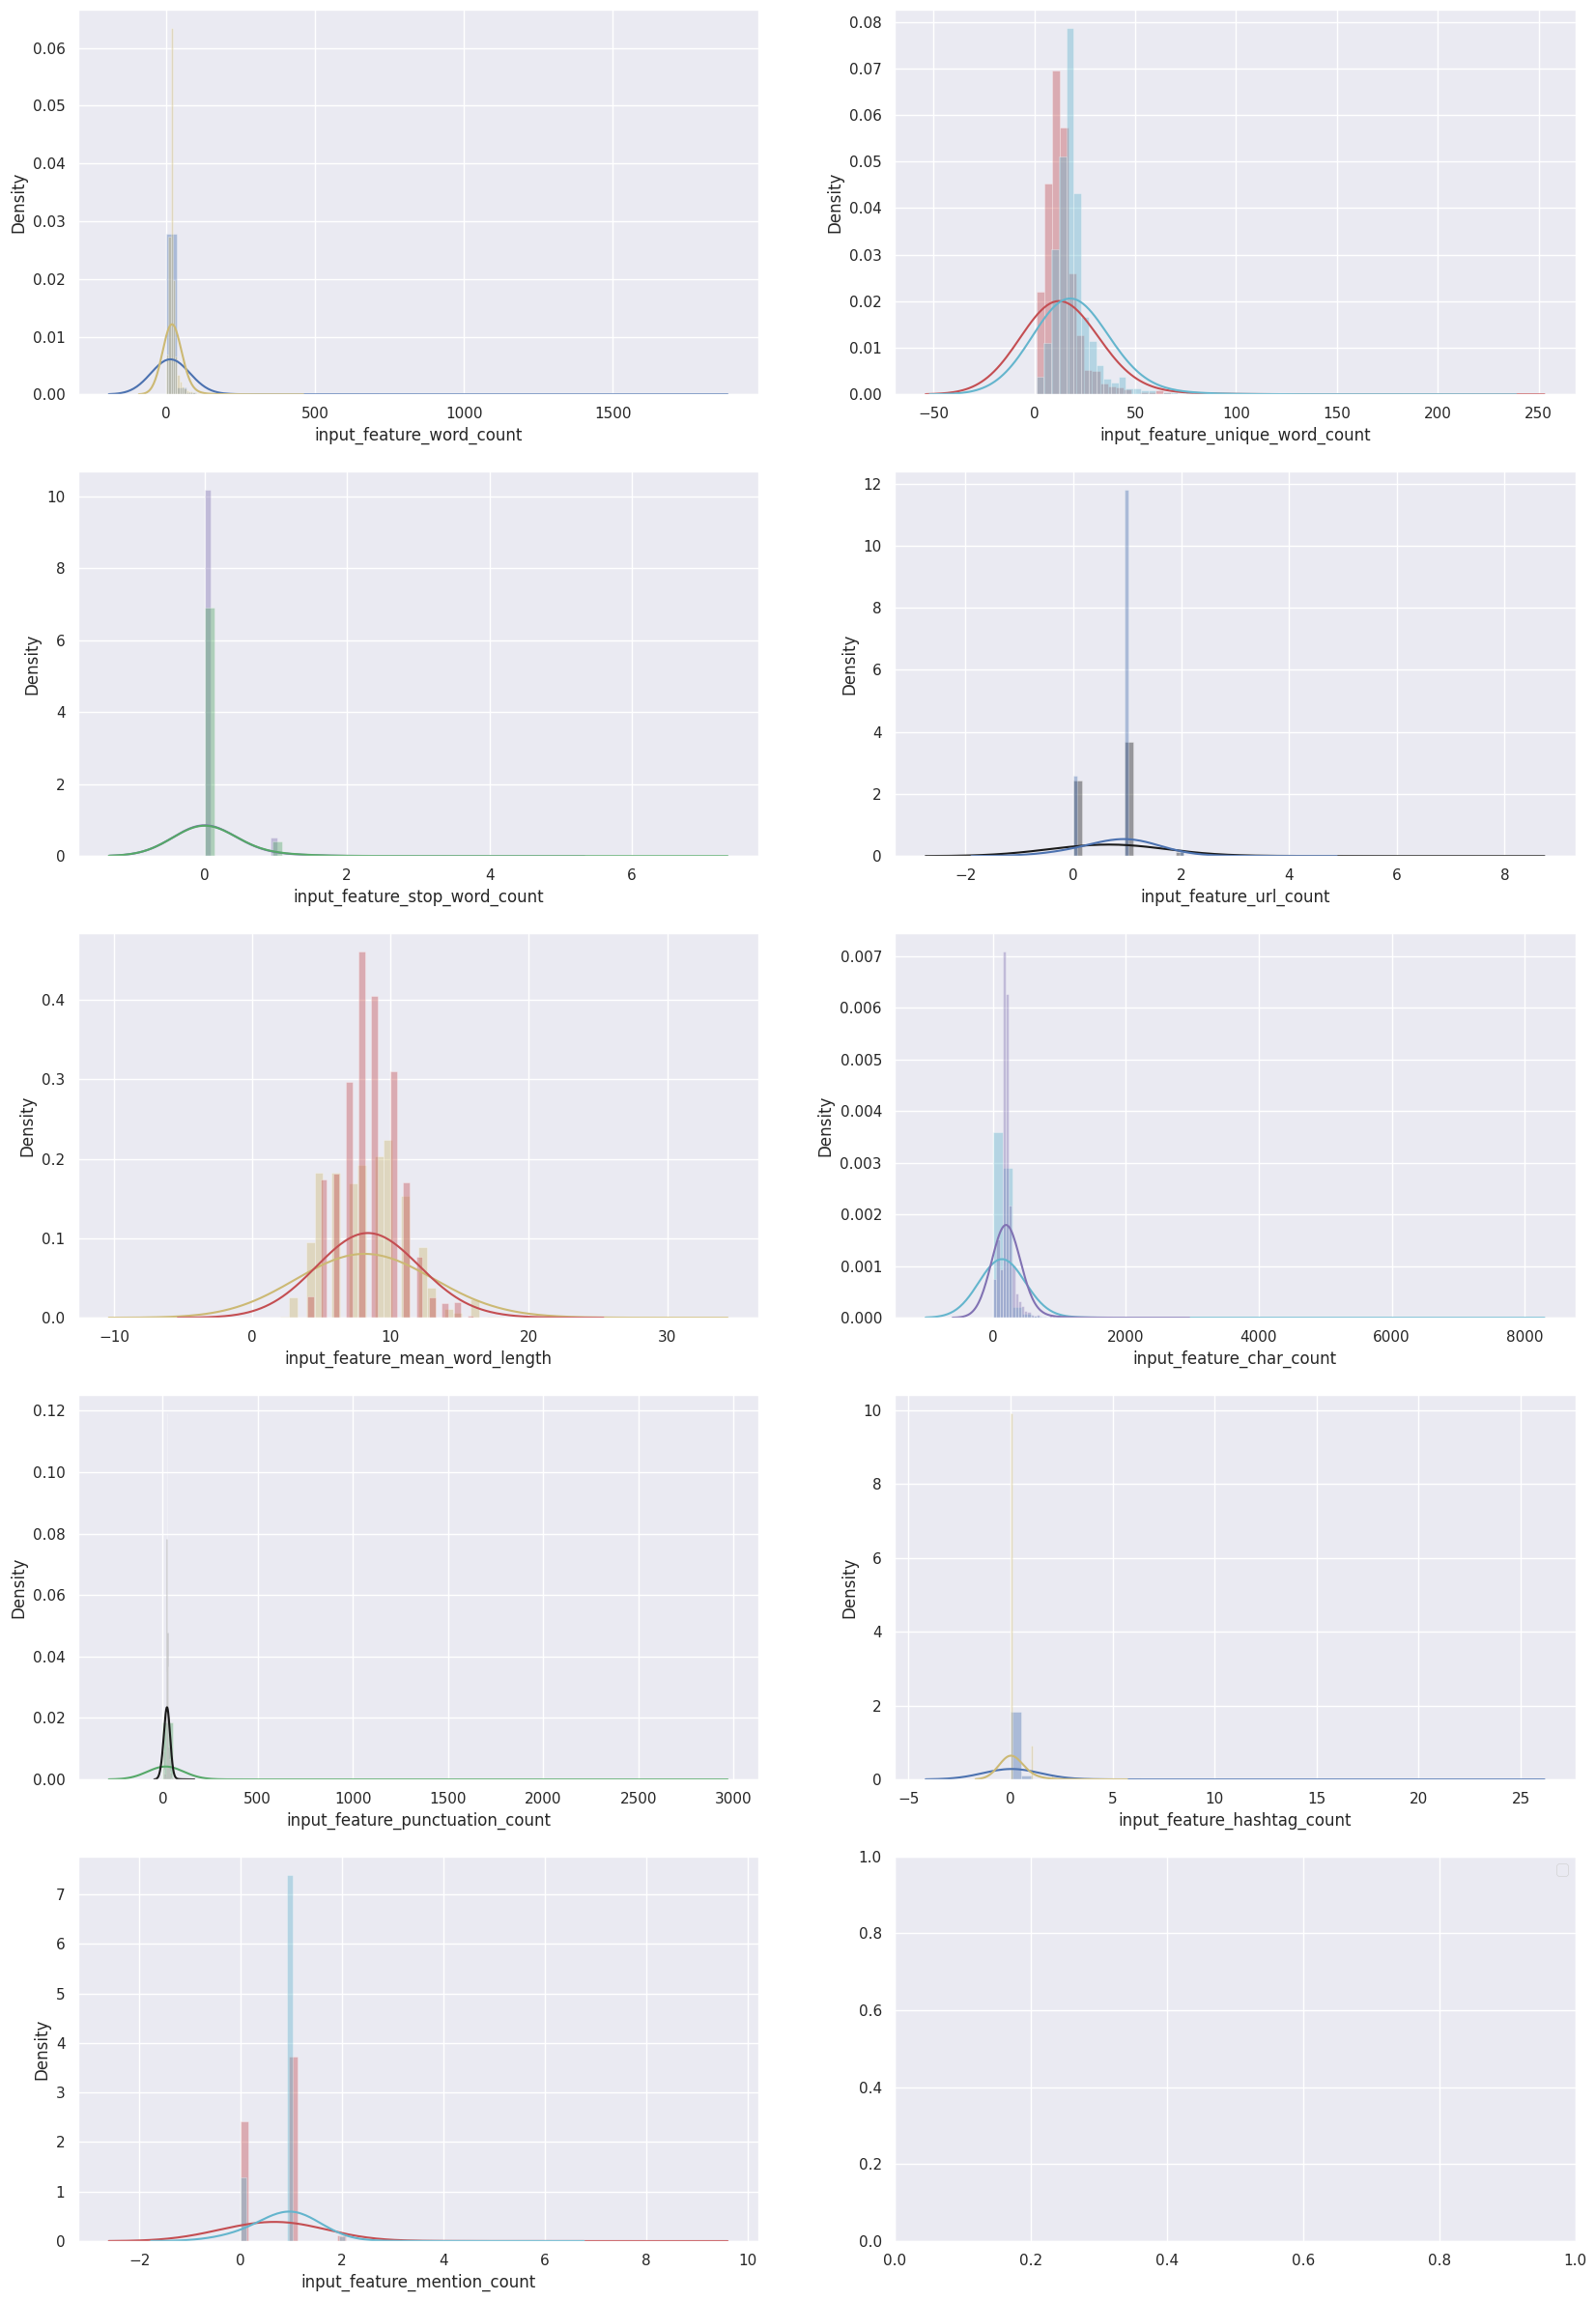

    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for input_feature column
    Faster text processing using clean_tweets function, since top_num_features exceeds 300
Train data Text cleaning completed. Time taken = 9 seconds

For target = target

    For class = 0
Top 200 n-grams
: ['fix', 'test', 'ad', 'add', 'updat', 'merg', 'remov', 'branch', 'use', 'releas', 'trunk', 'file', 'prepar', 'version', 'chang', 'close', 'mavenreleaseplugin', 'svnapacheorgreposasfincubatorjspwikitrunk', 'code', 'new', 'commit', 'develop', 'pdfbox', 'support', 'javadoc', 'work', 'class', 'storm', 'move', 'x', 'method', 'jcr', 'error', 'set', 'nt', 'patch', 'issu', 'name', 'type', 'log', 'svnapacheorgreposasfmavencomponentstrunk', 'creat', 'phoenix', 'svnapacheorgreposasfpdfboxtrunk', 'iter', 'make', 'bug', 'document', 'next', 'case', 'review', 'tag', 'refactor', 'comment', 'minor', 'build', 'plugin', 'derbi', 'svnapacheorgreposasfincubatorjenaimportjenasv

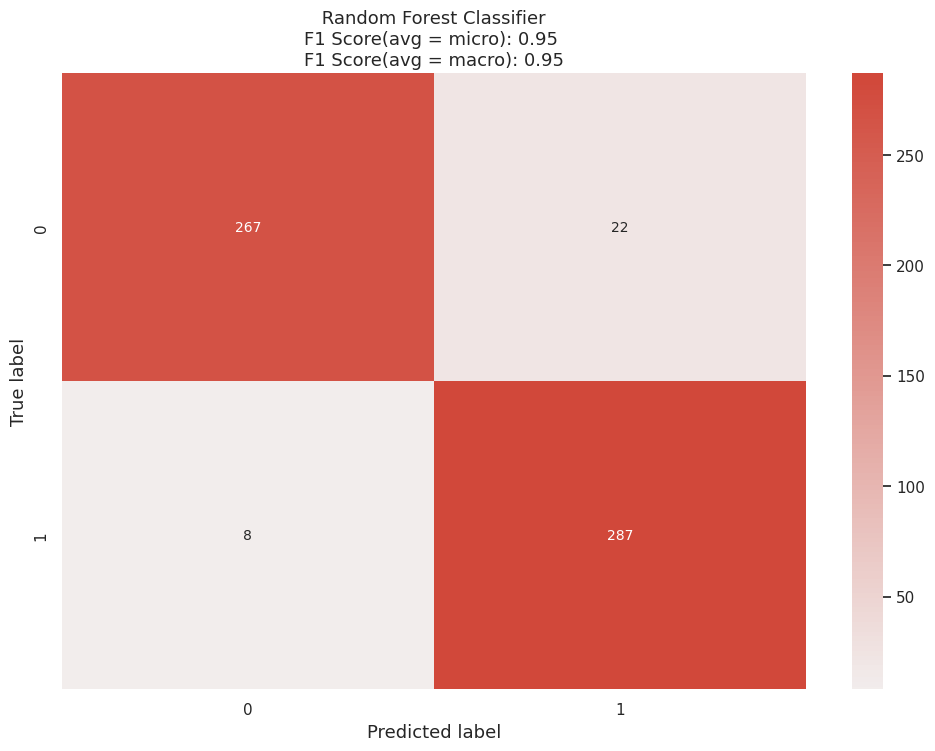

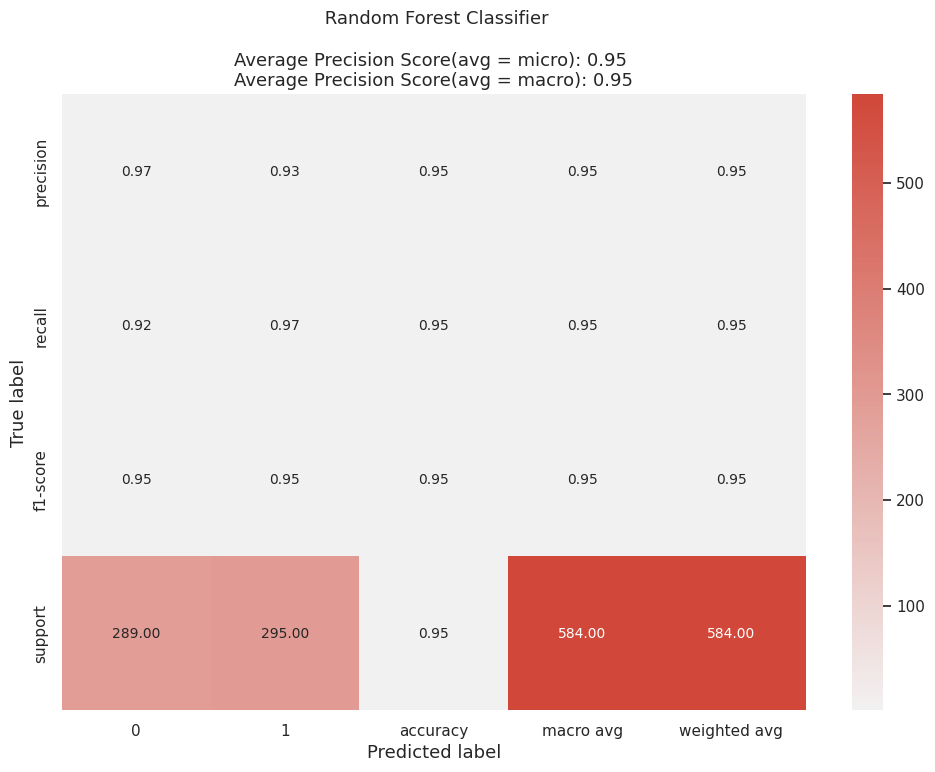

  Now transforming Train data to return as output...
  Transforming Test data to return as output...
Training best Auto_NLP Pipeline on full Train data...will be faster since best params are known
    Returning best Auto_NLP pipeline to transform and make predictions on test data...
Training completed. Time taken for Auto_NLP = 2.2 minutes


In [10]:
train_x, test_x, final, predicted = Auto_NLP('input_feature', 
                                            train,
                                            test,
                                            'target',
                                            score_type='weighted-f1',
                                            modeltype='Classification',
                                            verbose=2,
                                            build_model=True)

Now let's get the parameters for the best pipeline

In [11]:
final.get_params()

{'memory': None,
 'steps': [('functiontransformer',
   FunctionTransformer(func=<function Auto_NLP.<locals>.<lambda> at 0x7fccd9c67520>)),
  ('tfidfvectorizer',
   TfidfVectorizer(encoding='latin-1', max_df=0.23622995216793718,
                   max_features=920, min_df=2, ngram_range=(1, 3),
                   sublinear_tf=True, token_pattern='\\w{1,}')),
  ('selectkbest',
   SelectKBest(k=920, score_func=<function chi2 at 0x7fcd56f556c0>)),
  ('calibratedclassifiercv',
   CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=200,
                                                                n_jobs=-1,
                                                                random_state=99),
                          cv=3, method='isotonic'))],
 'verbose': False,
 'functiontransformer': FunctionTransformer(func=<function Auto_NLP.<locals>.<lambda> at 0x7fccd9c67520>),
 'tfidfvectorizer': TfidfVectorizer(encoding='latin-1', max_df=0.23622995216793718,
                 max

We are only interested in the best parameters for the vectorizer, which is the second step

In [12]:
print(final.get_params()['steps'][1][1])

TfidfVectorizer(encoding='latin-1', max_df=0.23622995216793718,
                max_features=920, min_df=2, ngram_range=(1, 3),
                sublinear_tf=True, token_pattern='\\w{1,}')


To make predictions, you don't need to manually vectorize the input, only pass in a DataFrame column

In [17]:
input = [
    "check nullity to fail earlier, to help isolate IVY-355",
    "Trying to minimize the number of simultaneous open connections by following the guidelines mentioned in http://java.sun.com/j2se/1.5.0/docs/guide/net/http-keepalive.html (IVY-1105)",
    "Fixed an event resetting issue in ODE. \n When several discrete events occur during the same ODE integration step, \n they are handled chronologically or reverse chronologically depending on \n the integration direction. If one of the event truncates the step (for \n example because its eventOccurred method returns RESET or \n RESET_DERIVATIVES for example), the stepAccepted method of the pending \n events later in the step were not called. This implied that in the next \n step, these events were still referring to data from previous step, they \n had lost synchronization with the integrator. \n JIRA: MATH-695",
    "Just some hacks to allow multiline plugins.  Not functional yet.",
    "removing schemas.",
    "Move Serializable from interface to implementations"
]
dfInput = pd.DataFrame(input, columns=['message'])
final.predict(dfInput['message'])

array([1, 1, 1, 0, 0, 0])